# How Good is this Firm, cont'd: Tell Me in Real Time!

Your boss was very pleased with the MCMC estimator you came up with previously. Impressed by your statistics and programming skills, he now asks you to build a system capable of providing a continuously-updated estimate as data comes in. 

MCMC is not suitable for this task&mdash;remember how it took tens of thousands of time steps before the estimate stablized? If data were to come in continuously, this would simply be too slow for all but the simpliest models. Fortunately, you have previously heard about a technique called *particle filtering*. Particle filtering is commonly deployed in situations that require continuous processing of data, such as GPS positioning (perhaps because you have watched <a href="https://www.youtube.com/watch?v=aUkBa1zMKv4&t=313s">this video</a> on YouTube.)

<!--In computer science, an algorithm that processes data as they come in is called an *online algorithm*.  -->

### Data 

We start with creating some data. In this case, we want 60 observations with an average success rate of 2/3:

In [74]:
import numpy as np

Y = np.random.randint(0,3,60)
Y[Y==2] = 1
print(Y)
print("Actual success rate:",np.sum(Y)/len(Y))

[0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1]
Actual success rate: 0.6666666666666666


We will sequentially take one value from $Y$ at each time step, which we will treat as our "real-time" data.

### Particle Filter

The concept of particle filtering is actually very simple: 
- We start with a random sample of possible values, called particles.
- Everytime new data comes in, 
 - we weigh each particle base on how well it explain the data.
 - We generate new particles from old ones. Particles with higher weights are more likely to be resampled. 
 
As data accumulates, we will eventually be left with samples that have explained the data well.

In [136]:
#Particle filter

p_count = 100 #Number of particles

import numpy as np
import random

def get_weight(X,y):
    #Weight X based on P(y|X)
    pyx = [[0.5,0.5],[0.3,0.7]]
    W = np.asarray([pyx[x][y] for x in X_prev])
    W = W/np.sum(W)
    return W

def resample(X,W):
    #Stochastic universal resampling/systematic resampling
    new_samples = []    
    
    cW = np.cumsum(W)
    pointer_bias = random.uniform(0,1/p_count)
    cur_c = 0        
    for i in range(p_count):
        pointer = i/p_count + pointer_bias
        for c in range(cur_c,len(cW)):
            if cW[c] > pointer:
                new_samples.append(X[c])
                cur_c = c
                break    
    return np.asarray(new_samples)

#Main loop
X_prev = np.random.randint(0,2,p_count) #Initial random guess
X_list = [X_prev] #This holds our particles at each time step
for y in Y:
    W = get_weight(X_prev,y)     #Weight particles
    X_cur = resample(X_prev,W)   #Resample
    
    X_list.append(X_cur)
    X_prev = X_cur    

Let us plot the estimated chance that the firm is a good one in each time step:

Text(0,0.5,'% of particles with type=1')

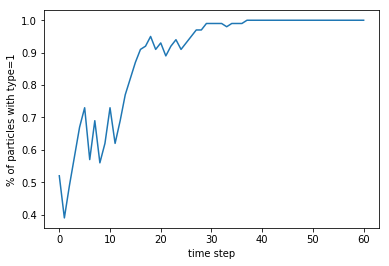

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

#Plot estimate at each time step
X_est = np.sum(X_list,axis=1) / p_count
fig, ax = plt.subplots()
ax.plot(X_est)    
ax.set_xlabel("time step")
ax.set_ylabel("% of particles with type=1")

It is quite clear that by step 30 it is virtually certain that the firm is a good one.

### Monitoring for Underlying Change

What is the point of processing data as it comes in, you might ask, 
if the underlying parameter of interest, X, never changes?
Parameters could indeed change in reality. Let us model a situation
where in each period, there is a small chance that a firm would switch type.

Our data consistent 100 observations generated by a good firm, 
followed by 100 observations generated by a bad firm. 
To make the change easier to pick up, a good firm now has a 90% chance of succeeding
in any given month:

In [202]:
Y1 = np.random.randint(0,10,100)
Y1[Y1<1] = 0
Y1[Y1>=1] = 1
Y2 = np.concatenate([Y1,np.random.randint(0,2,100)])

There are two changes we need to make to our particle filter to accommodate the possibility of
firms changing type:
- We need a model of how change happen. 
We will employ a very simple model in this case&mdash;
each firm has a 1% change of switching type in each period.  
- In every time step, we alter our particles according to the model 
before we calculate new weights.

Text(0,0.5,'% of particles with type=1')

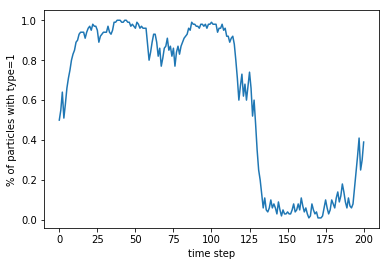

In [204]:
p_count = 100 #Number of particles

def update_X(X):
    #Update X
    rand_vec = np.random.rand(*X.shape)
    X = np.where(rand_vec>=0.99,1-X,X)
    return X

#Main loop
X_prev = np.random.randint(0,2,p_count) #Initial random guess
X_list = [X_prev] #This holds our particles at each time step
for y in Y2:
    X_prev = update_X(X_prev)    #Update X
    W = get_weight(X_prev,y)     #Weight particles
    X_cur = resample(X_prev,W)   #Resample
    
    X_list.append(X_cur)
    X_prev = X_cur    
    
%matplotlib inline
import matplotlib.pyplot as plt

#Plot estimate at each time step
X_est = np.sum(X_list,axis=1) / p_count
fig, ax = plt.subplots()
ax.plot(X_est)    
ax.set_xlabel("time step")
ax.set_ylabel("% of particles with type=1")    

It worked! Our algorithm detected the type switch not long after time step 100. If you re-run the code a few times though, you will see that things do not always work out so nicely&mdash;bad firms sometimes get lucky and have a few consecutive rounds of good performance, making it hard to detect the change. 

### Continuous Type

As a final example, let us once again modify the script to accommodate continuous type:

Most probable type: 0.65


Text(0,0.5,'most probably type')

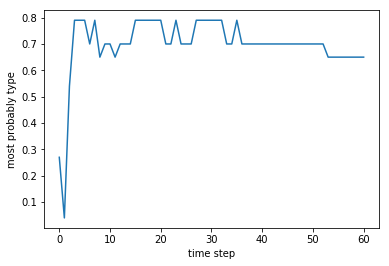

In [111]:
#Particle filter

p_count = 5000 #Number of particles

def get_weight(X,y):
    #Weight X based on P(y|X)
    if y==1:
        W = X
    else:
        W = 1 - X
    return W/np.sum(W)

#Main loop
X_prev = np.random.rand(p_count) #Initial random guess
X_list = [X_prev] #This holds our particles at each time step
for y in Y:
    W = get_weight(X_prev,y)     #Weight particles
    X_cur = resample(X_prev,W)   #Resample
    
    X_list.append(X_cur)
    X_prev = X_cur    
    
#Plot estimate at each time step
from scipy import stats
X_list = np.round(X_list,2)
X_est = stats.mode(X_list,axis=1)[0].flatten() #Find the most common type
print("Most probable type:",X_est[-1])
fig, ax = plt.subplots()
ax.plot(X_est)    
ax.set_xlabel("time step")
ax.set_ylabel("most probably type")    